<a href="https://colab.research.google.com/github/coatless/pyopensci-eic/blob/main/i243-vargram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install package

In [1]:
!pip install vargram

# Download sample data

In [22]:
import requests
import zipfile
import os
import tempfile
import shutil
from pathlib import Path
from typing import Optional, Union, Tuple

def setup_test_data(
    repo: str = "pgcbioinfo/vargram",
    source_path: str = "tests/test_data",
    target_dir: Optional[Union[str, Path]] = None
) -> Path:
    """
    Download the latest release of a GitHub repository and extract a specific directory's
    contents to a target directory.

    This function is useful for setting up test data for a package. It fetches the latest
    release from GitHub, extracts the specified directory's contents, and places them
    directly in the target directory.

    Parameters
    ----------
    repo : str, default "pgcbioinfo/vargram"
        The GitHub repository in format "owner/repo".
    source_path : str, default "tests/test_data"
        Path within the repository to extract. This directory's contents will be
        placed in the target directory.
    target_dir : str or Path, optional
        Directory where the contents should be extracted. If None, the current
        working directory is used.

    Returns
    -------
    Path
        A Path object pointing to the target directory where files were extracted.

    Raises
    ------
    requests.HTTPError
        If the API request to GitHub fails.
    FileNotFoundError
        If the specified source_path doesn't exist in the repository.
    ValueError
        If the repository format is invalid.

    Examples
    --------
    >>> # Extract to current directory
    >>> data_path = setup_test_data()
    >>>
    >>> # Extract to a specific directory
    >>> data_path = setup_test_data(target_dir="./my_test_data")
    >>>
    >>> # Extract a different path from a different repo
    >>> data_path = setup_test_data(
    ...     repo="username/repo",
    ...     source_path="data/examples",
    ...     target_dir="./examples"
    ... )
    """
    # Validate repo format
    if not repo or "/" not in repo:
        raise ValueError(f"Invalid repository format: {repo}. Expected format: 'owner/repo'")

    # Convert target_dir to Path if specified, otherwise use current directory
    if target_dir is None:
        target_dir = Path.cwd()
    else:
        target_dir = Path(target_dir)
        target_dir.mkdir(parents=True, exist_ok=True)

    # Step 1: Get the latest release information
    print(f"Getting latest release for {repo}...")
    response = requests.get(f"https://api.github.com/repos/{repo}/releases/latest")
    response.raise_for_status()  # Raise an exception for HTTP errors
    release_data = response.json()
    zipball_url = release_data["zipball_url"]
    release_tag = release_data["tag_name"]
    print(f"Found release: {release_tag}")

    # Step 2: Download the release zip file
    print(f"Downloading release from {zipball_url}...")
    zip_response = requests.get(zipball_url, stream=True)
    zip_response.raise_for_status()

    # Create temporary files
    with tempfile.NamedTemporaryFile(delete=False, suffix='.zip') as temp_zip:
        # Write the downloaded zip to the temporary file
        for chunk in zip_response.iter_content(chunk_size=8192):
            temp_zip.write(chunk)
        temp_zip_path = temp_zip.name

    temp_dir = tempfile.mkdtemp()

    try:
        # Step 3: Extract the archive
        print("Extracting the release...")
        with zipfile.ZipFile(temp_zip_path, 'r') as zip_ref:
            zip_ref.extractall(temp_dir)

        # Step 4: Find the extracted directory
        extracted_dir = next(Path(temp_dir).iterdir())  # Get the first (and only) directory

        # Step 5: Check if the source path directory exists
        source_data_path = extracted_dir / source_path
        if not source_data_path.exists():
            raise FileNotFoundError(f"{source_path} directory not found in the release")

        # Step 6: Copy each item from source directory directly to the target directory
        print(f"Copying contents of {source_path} to {target_dir}...")
        for item in source_data_path.iterdir():
            dest_path = target_dir / item.name

            # If it's a directory, copy the entire directory tree
            if item.is_dir():
                if dest_path.exists():
                    shutil.rmtree(dest_path)
                shutil.copytree(item, dest_path)
            # If it's a file, just copy the file
            else:
                if dest_path.exists():
                    os.remove(dest_path)
                shutil.copy2(item, dest_path)

        print(f"Successfully extracted {source_path} contents to {target_dir}")

        return target_dir

    finally:
        # Step 7: Clean up temporary files
        os.unlink(temp_zip_path)
        shutil.rmtree(temp_dir)

setup_test_data()

Getting latest release for pgcbioinfo/vargram...
Found release: v0.3.0
Extracting the release...
Copying contents of tests/test_data to /content...
Successfully extracted tests/test_data contents to /content


PosixPath('/content')

# Verify first example

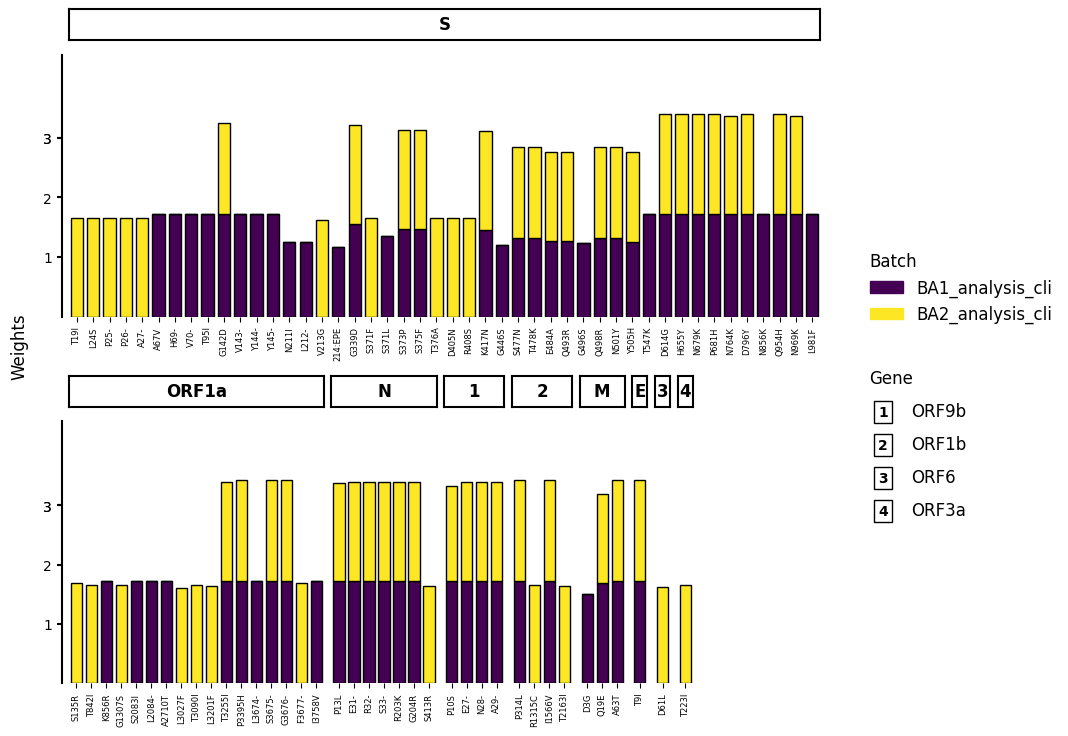

In [18]:
from vargram import vargram # Importing vargram class

vg = vargram(data='analysis/omicron_analysis_cli.tsv') # Provide data
vg.profile() # Tell VARGRAM you want to create a mutation profile
vg.show() # Show the figure
vg.save("default_profile.png", dpi=300) # Save the figure